## Fase 1: Carga y Preparación de Datos

- Cargar dataset
- Normalizar
- Split 80/20

# Proyecto 2: Reducción de la Dimensionalidad

Dataset: Fashion-MNIST (70,000 imágenes de 28×28 píxeles)

Objetivo: Comparar técnicas de reducción de dimensionalidad y clasificadores

---

In [2]:
terminado = True

if terminado:
    import dill
    dill.load_session('notebook_env.db')

### Imports

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import struct
import warnings
from pathlib import Path
from sklearn.model_selection import train_test_split
import gdown
from sklearn.model_selection import GridSearchCV
import dill

warnings.filterwarnings('ignore')
%matplotlib inline

np.random.seed(42)

print("Librerías cargadas")

Librerías cargadas


### Funciones para leer datos

### Cargar datos

In [4]:
def download_data(file_id, name_file):
    url = f"https://drive.google.com/uc?id={file_id}"
    gdown.download(url, name_file, quiet=False)
    return name_file


def read_labels(file_path):
    class_names = {
        0: "T-shirt/top",
        1: "Trouser",
        2: "Pullover",
        3: "Dress",
        4: "Coat",
        5: "Sandal",
        6: "Shirt",
        7: "Sneaker",
        8: "Bag",
        9: "Ankle boot",
    }

    with open(file_path, "rb") as f:
        magic, num_labels = struct.unpack(">II", f.read(8))
        labels = np.frombuffer(f.read(), dtype=np.uint8)
    df = pd.DataFrame(labels, columns=["label"])
    df["class_name"] = df["label"].map(class_names)
    return df


def extrar_feature_images(file_path):

    with open(file_path, "rb") as f:
        magic, num_images, rows, cols = struct.unpack(">IIII", f.read(16))
        print("Número de imágenes:", num_images)
        print("Dimensiones de cada imagen:", rows, "x", cols)
        image_data = np.frombuffer(f.read(), dtype=np.uint8)
        images = image_data.reshape(num_images, rows, cols)
        X = images.reshape(num_images, rows * cols)
        print("Forma de la matriz final:", X.shape)
    return X


def Show_Image(X, nro_imagen):
    if nro_imagen < 0 or nro_imagen >= X.shape[0]:
        raise IndexError(
            f"El índice {nro_imagen} está fuera de rango. Debe estar entre 0 y {X.shape[0]-1}"
        )

    img = X[nro_imagen].reshape(28, 28)
    plt.imshow(img, cmap="gray")
    plt.title(f"Imagen #{nro_imagen}")
    plt.axis("off")
    plt.show()


# Descargando la data solo la primera vez
if not Path("data").exists():
    Path("data").mkdir(parents=True, exist_ok=True)

    file_train_X = download_data("1enziBIpqiv_t95KQcifsclNH2BdR8lAd", "data/train_X")
    file_test_X = download_data("1Jeax6tnQ6Nmr2PTNXdQqzKnN0YqtrLe4", "data/test_X")
    file_train_Y = download_data("1MZtn2iA5cgiYT1i3O0ECuR01oD0kGHh7", "data/train_Y")
    file_test_Y = download_data("1K5pxwk2s3RDYsYuwv8RftJTXZ-RGR7K4", "data/test_Y")


    train_X = extrar_feature_images(file_train_X)
    test_X = extrar_feature_images(file_test_X)
    train_Y = read_labels(file_train_Y)
    test_Y = read_labels(file_test_Y)


    print("Data train : ", train_X.shape)
    print("Label train : ", train_Y.shape)
    print("Data test : ", test_X.shape)
    print("Label test : ", test_Y.shape)


Downloading...
From: https://drive.google.com/uc?id=1enziBIpqiv_t95KQcifsclNH2BdR8lAd
To: /Users/stewart/2025-2/ML/proyecto2_ML/data/train_X
100%|██████████| 47.0M/47.0M [00:02<00:00, 17.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Jeax6tnQ6Nmr2PTNXdQqzKnN0YqtrLe4
To: /Users/stewart/2025-2/ML/proyecto2_ML/data/test_X
100%|██████████| 7.84M/7.84M [00:00<00:00, 8.42MB/s]
Downloading...
From: https://drive.google.com/uc?id=1MZtn2iA5cgiYT1i3O0ECuR01oD0kGHh7
To: /Users/stewart/2025-2/ML/proyecto2_ML/data/train_Y
100%|██████████| 60.0k/60.0k [00:00<00:00, 311kB/s]
Downloading...
From: https://drive.google.com/uc?id=1K5pxwk2s3RDYsYuwv8RftJTXZ-RGR7K4
To: /Users/stewart/2025-2/ML/proyecto2_ML/data/test_Y
100%|██████████| 10.0k/10.0k [00:00<00:00, 551kB/s]

Número de imágenes: 60000
Dimensiones de cada imagen: 28 x 28
Forma de la matriz final: (60000, 784)
Número de imágenes: 10000
Dimensiones de cada imagen: 28 x 28
Forma de la matriz final: (10000, 784)
Data train :  (60000, 784)
Label train :  (60000, 2)
Data test :  (10000, 784)
Label test :  (10000, 2)


In [5]:
if not terminado:
    # Cargar los datos
    print("Cargando entrenamiento...")
    train_X_raw = extrar_feature_images("data/train_X")
    train_Y = read_labels("data/train_Y")
    print("Cargando prueba...")
    test_X_raw = extrar_feature_images("data/test_X")
    test_Y = read_labels("data/test_Y")

    # Limitar a 100% de los datos
    percent = 100
    train_X_raw = train_X_raw[:int(train_X_raw.shape[0] * percent/100)]
    train_Y = train_Y.iloc[:int(train_Y.shape[0] * percent/100)]
    test_X_raw = test_X_raw[:int(test_X_raw.shape[0] * percent/100)]
    test_Y = test_Y.iloc[:int(test_Y.shape[0] * percent/100)]


print(f"\nDatos cargados:")
print(f"Train: {train_X_raw.shape}, {train_Y.shape}")
print(f"Test: {test_X_raw.shape}, {test_Y.shape}")


Datos cargados:
Train: (60000, 784), (60000, 2)
Test: (10000, 784), (10000, 2)


### Exploración

In [6]:
# Ver estadísticas básicas
print(f"Rango: [{train_X_raw.min()}, {train_X_raw.max()}]")
print(f"Media: {train_X_raw.mean():.2f}")
print(f"Std: {train_X_raw.std():.2f}")

Rango: [0.0, 255.0]
Media: 72.94
Std: 90.02


class_name
Ankle boot     6000
T-shirt/top    6000
Dress          6000
Pullover       6000
Sneaker        6000
Sandal         6000
Trouser        6000
Shirt          6000
Coat           6000
Bag            6000
Name: count, dtype: int64


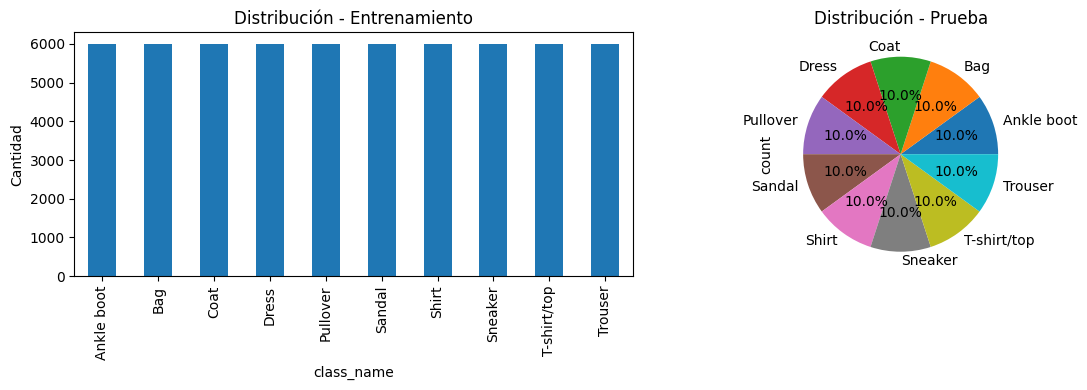

In [7]:
# Distribución de clases
print(train_Y['class_name'].value_counts())

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

train_Y['class_name'].value_counts().sort_index().plot(kind='bar', ax=axes[0])
axes[0].set_title('Distribución - Entrenamiento')
axes[0].set_ylabel('Cantidad')

test_Y['class_name'].value_counts().sort_index().plot(kind='pie', ax=axes[1], autopct='%1.1f%%')
axes[1].set_title('Distribución - Prueba')

plt.tight_layout()
plt.show()

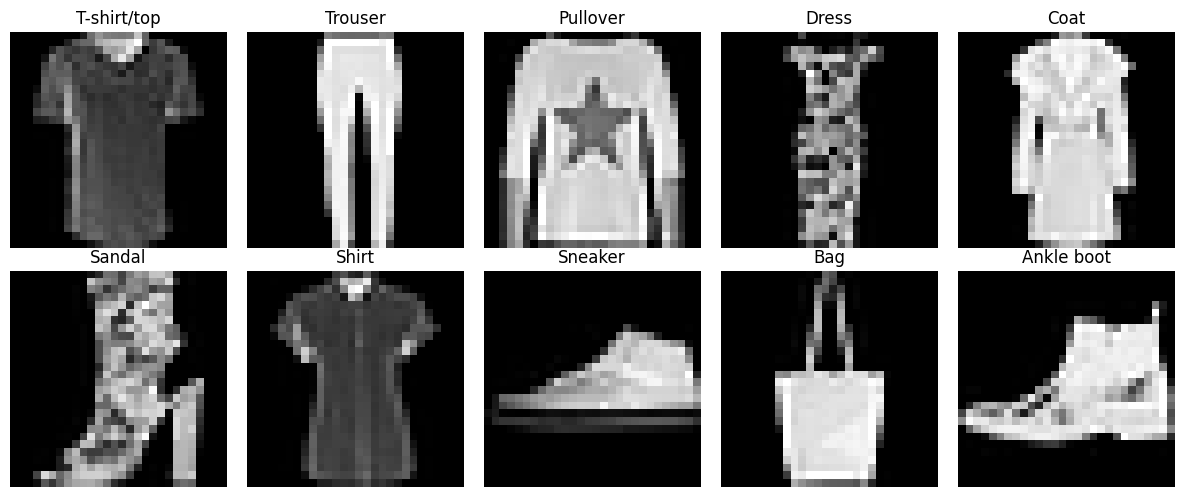

In [8]:
# Ver algunas imágenes de ejemplo
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
axes = axes.ravel()

for i in range(10):
    idx = train_Y[train_Y['label'] == i].sample(1).index[0]
    img = train_X_raw[idx].reshape(28, 28)
    axes[i].imshow(img, cmap='gray')
    axes[i].set_title(f'{train_Y.loc[idx, "class_name"]}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

### Normalización

In [9]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import numpy as np
if not terminado:
    # --- 1. Convertir a float32 de forma segura ---
    train_X_raw = np.array(train_X_raw, dtype=np.float32)
    test_X_raw = np.array(test_X_raw, dtype=np.float32)

    # --- 2. Normalizar a [0, 1] para mantener estabilidad (por si eran imágenes) ---
    train_X_normalized = train_X_raw / 255.0
    test_X_normalized = test_X_raw / 255.0

    # --- 3. Estandarizar con StandardScaler (media 0, varianza 1) ---
    # Esto ayuda a que métodos como PCA, LogisticRegression o SVM converjan más rápido
    scaler = StandardScaler()

    train_X_scaled = scaler.fit_transform(train_X_normalized)
    test_X_scaled = scaler.transform(test_X_normalized)

# --- 4. Mostrar resumen de los datos ---
print("Preprocesamiento completo ✅")
print(f"Train: media={train_X_scaled.mean():.4f}, desviación={train_X_scaled.std():.4f}")
print(f"Test:  media={test_X_scaled.mean():.4f}, desviación={test_X_scaled.std():.4f}")
print(f"Forma final: train={train_X_scaled.shape}, test={test_X_scaled.shape}")


Preprocesamiento completo ✅
Train: media=-0.0000, desviación=1.0000
Test:  media=0.0025, desviación=1.0085
Forma final: train=(60000, 784), test=(10000, 784)


### Split de datos

In [10]:
if not terminado:
    # Split 80/20
    X_train, X_val, y_train, y_val = train_test_split(
        train_X_scaled,
        train_Y['label'].values,
        test_size=0.20,
        random_state=42,
        stratify=train_Y['label'].values
    )

    X_test = test_X_scaled
    y_test = test_Y['label'].values

    print(f"Train: {X_train.shape}")
    print(f"Val: {X_val.shape}")
    print(f"Test: {X_test.shape}")


    # data para NMF
    X_train_norm, X_val_norm, y_train_norm, y_val_norm = train_test_split(
        train_X_normalized,
        train_Y['label'].values,
        test_size=0.20,
        random_state=42,
        stratify=train_Y['label'].values
    )

    X_test_norm = test_X_normalized
    y_test_norm = test_Y['label'].values

    print(f"Train: {X_train.shape}")
    print(f"Val: {X_val.shape}")
    print(f"Test: {X_test.shape}")


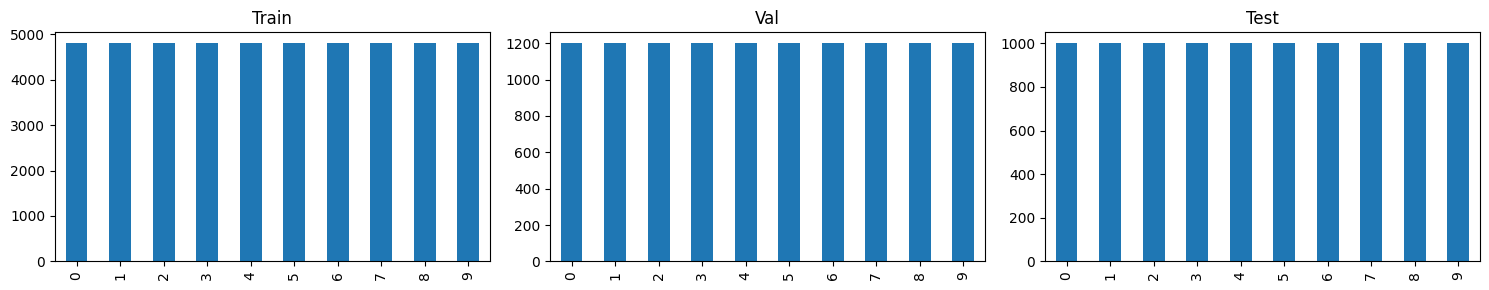

In [11]:
# Verificar que las clases estén balanceadas
fig, axes = plt.subplots(1, 3, figsize=(15, 3))

pd.Series(y_train).value_counts().sort_index().plot(kind='bar', ax=axes[0])
axes[0].set_title('Train')

pd.Series(y_val).value_counts().sort_index().plot(kind='bar', ax=axes[1])
axes[1].set_title('Val')

pd.Series(y_test).value_counts().sort_index().plot(kind='bar', ax=axes[2])
axes[2].set_title('Test')

plt.tight_layout()
plt.show()

### Resumen

In [12]:
# Resumen
print("Resumen de datos:")
print(f"Entrenamiento: {X_train.shape[0]} muestras")
print(f"Validación: {X_val.shape[0]} muestras")
print(f"Prueba: {X_test.shape[0]} muestras")
print(f"Total: {X_train.shape[0] + X_val.shape[0] + X_test.shape[0]} muestras")
print(f"Features: {X_train.shape[1]}")

Resumen de datos:
Entrenamiento: 48000 muestras
Validación: 12000 muestras
Prueba: 10000 muestras
Total: 70000 muestras
Features: 784


---

## Fase 2: Reducción de Dimensionalidad

Técnicas a implementar:
- PCA
- NMF
- t-SNE
- UMAP
- Isomap
- Spectral Embedding

### Imports para reducción

In [13]:
from sklearn.decomposition import PCA, NMF
from sklearn.manifold import TSNE, Isomap, SpectralEmbedding
import umap
import time

### PCA

In [14]:
# Aplicar PCA
if not terminado:
    print("Aplicando PCA...")
    start = time.time()
    pca = PCA(n_components=50, random_state=42)
    X_train_pca = pca.fit_transform(X_train)
    X_val_pca = pca.transform(X_val)
    X_test_pca = pca.transform(X_test)
print(f"Tiempo: {time.time()-start:.2f}s")

print(f"Varianza explicada: {pca.explained_variance_ratio_.sum():.4f}")
print(f"Shape: {X_train_pca.shape}")

Tiempo: 9517.91s
Varianza explicada: 0.8016
Shape: (48000, 50)


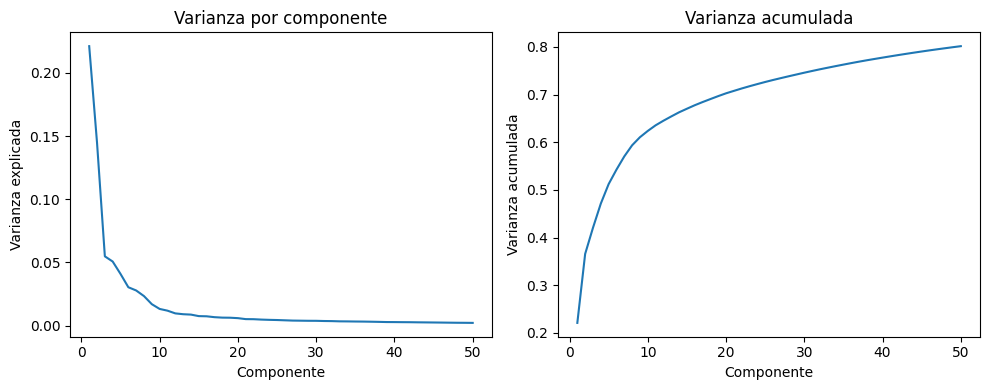

In [15]:
# Visualizar varianza explicada
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(range(1, 51), pca.explained_variance_ratio_)
plt.xlabel('Componente')
plt.ylabel('Varianza explicada')
plt.title('Varianza por componente')

plt.subplot(1, 2, 2)
plt.plot(range(1, 51), np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Componente')
plt.ylabel('Varianza acumulada')
plt.title('Varianza acumulada')
plt.tight_layout()
plt.show()

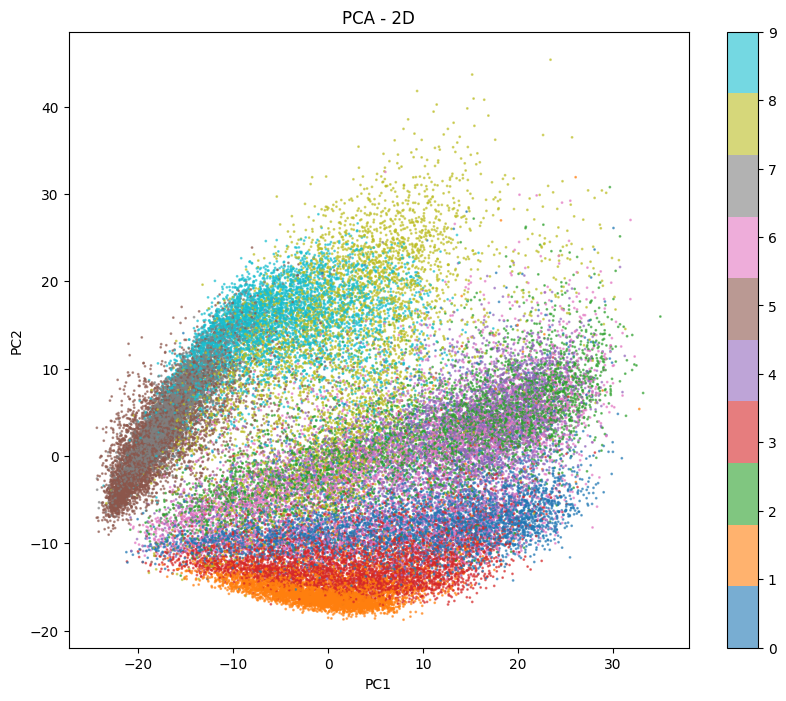

In [16]:
# PCA 2D para visualización
if not terminado:
    print("Aplicando PCA 2D para visualización...")
    pca_2d = PCA(n_components=2, random_state=42)
    X_train_pca_2d = pca_2d.fit_transform(X_train)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_train_pca_2d[:, 0], X_train_pca_2d[:, 1],
                     c=y_train, cmap='tab10', alpha=0.6, s=1)
plt.colorbar(scatter)
plt.title('PCA - 2D')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

### NMF

In [17]:
# Aplicar NMF
if not terminado:
    print("Aplicando NMF...")
    start = time.time()
    nmf = NMF(n_components=50, random_state=42, max_iter=500)
    X_train_nmf = nmf.fit_transform(X_train_norm)
    X_val_nmf = nmf.transform(X_val_norm)
    X_test_nmf = nmf.transform(X_test_norm)
    print(f"Tiempo: {time.time()-start:.2f}s")
    print(f"Shape: {X_train_nmf.shape}")

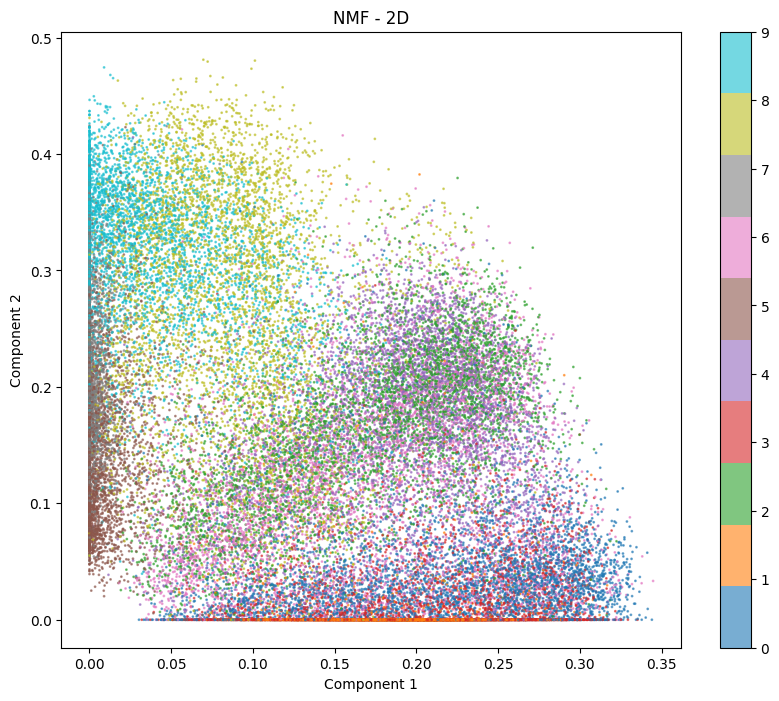

In [18]:
# NMF 2D para visualización
if not terminado:
    nmf_2d = NMF(n_components=2, random_state=42, max_iter=500)
    X_train_nmf_2d = nmf_2d.fit_transform(X_train_norm)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_train_nmf_2d[:, 0], X_train_nmf_2d[:, 1],
                     c=y_train, cmap='tab10', alpha=0.6, s=1)
plt.colorbar(scatter)
plt.title('NMF - 2D')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()

### t-SNE

In [19]:
# t-SNE solo para visualización (2D)
if not terminado:
    print("Aplicando t-SNE (esto puede tardar varios minutos)...")
    start = time.time()
    tsne = TSNE(n_components=2, random_state=42, perplexity=30)
    X_train_tsne = tsne.fit_transform(X_train)
    print(f"Tiempo: {time.time()-start:.2f}s")

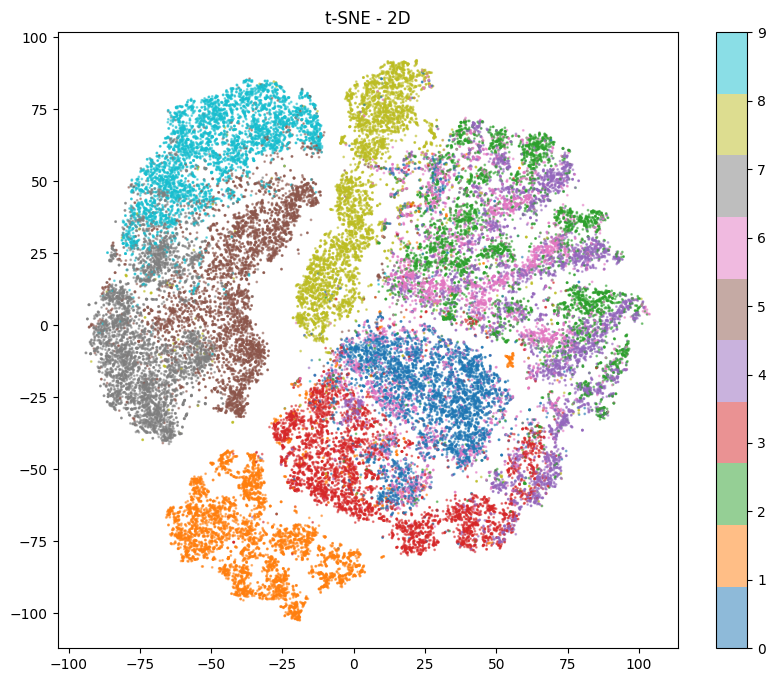

In [20]:
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_train_tsne[:, 0], X_train_tsne[:, 1],
                     c=y_train, cmap='tab10', alpha=0.5, s=1)
plt.colorbar(scatter)
plt.title('t-SNE - 2D')
plt.show()

### UMAP

In [21]:
# UMAP - 50 componentes
if not terminado:
    print("Aplicando UMAP (50 comp)...")
    start = time.time()
    umap_model = umap.UMAP(n_components=50, random_state=42, n_neighbors=15)
    X_train_umap = umap_model.fit_transform(X_train)
    X_val_umap = umap_model.transform(X_val)
    X_test_umap = umap_model.transform(X_test)
    print(f"Tiempo: {time.time()-start:.2f}s")
    print(f"Shape: {X_train_umap.shape}")

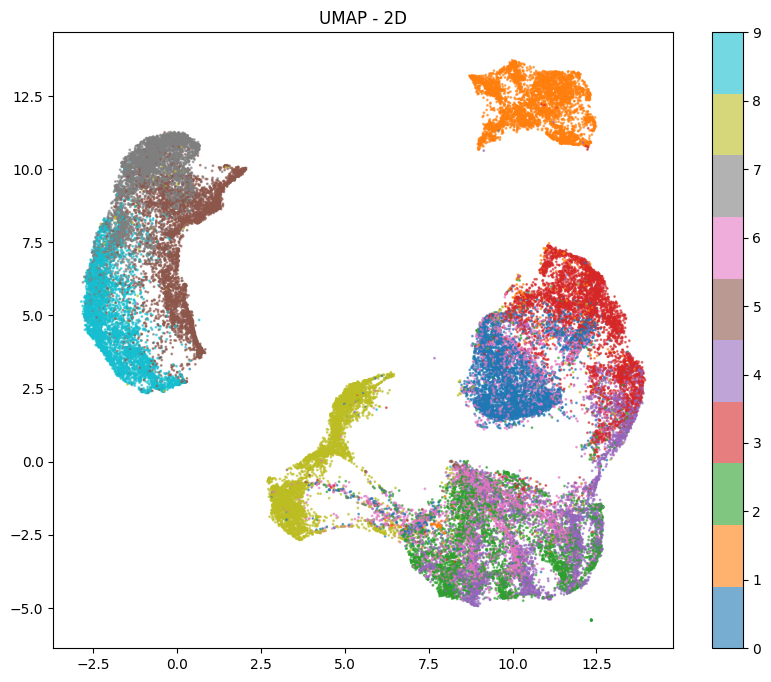

In [22]:
# UMAP 2D para visualización
if not terminado:
    umap_2d = umap.UMAP(n_components=2, random_state=42, n_neighbors=15)
    X_train_umap_2d = umap_2d.fit_transform(X_train)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_train_umap_2d[:, 0], X_train_umap_2d[:, 1],
                     c=y_train, cmap='tab10', alpha=0.6, s=1)
plt.colorbar(scatter)
plt.title('UMAP - 2D')
plt.show()

### Isomap (Isometric Mapping) - Solo Investigación

**¿Qué es?**
- Extensión no lineal de MDS (Multidimensional Scaling)
- Busca preservar distancias geodésicas (distancias en la superficie del manifold)
- Asume que los datos están en una variedad (manifold) no lineal inmersa en espacio de alta dimensión

**Algoritmo:**
1. Construir grafo de k-vecinos más cercanos
2. Calcular distancias geodésicas $d_G(i,j)$ usando caminos más cortos (Dijkstra/Floyd-Warshall)
3. Aplicar MDS clásico sobre matriz de distancias geodésicas

**Fórmula MDS:**
Minimizar: $E = \sum_{i,j} (d_G(i,j) - ||y_i - y_j||)^2$

donde $y_i$ son las coordenadas en espacio reducido.

**Ventajas:**
- Preserva estructura global del manifold
- Tiene transformación out-of-sample (aproximada)
- Bueno para manifolds convexos

**Desventajas:**
- Complejidad: O(n²) para construir grafo, O(n³) para eigendecomposition
- Sensible a ruido, outliers y "short-circuit edges"
- Parámetro k crítico: muy pequeño → grafo desconectado, muy grande → pierde estructura no lineal

**Por qué no se implementa aquí:**
- Con 48,000 muestras, toma más de 30 minutos
- Requiere almacenar matriz de distancias completa: ~9GB de RAM

### Spectral Embedding (Laplacian Eigenmaps) - Solo Investigación

**¿Qué es?**
- Técnica basada en teoría espectral de grafos
- Usa eigenvectors del Laplaciano del grafo para encontrar embedding
- Objetivo: preservar conectividad local (vecinos cercanos permanecen cerca)

**Algoritmo:**
1. Construir grafo de similitud: $W_{ij} = e^{-||x_i - x_j||^2 / 2\sigma^2}$ si i,j son vecinos
2. Calcular matriz de grados: $D_{ii} = \sum_j W_{ij}$
3. Calcular Laplaciano: $L = D - W$
4. Resolver problema de eigenvalores: $Lv = \lambda Dv$
5. Embedding = eigenvectors correspondientes a los k eigenvalores más pequeños (excepto el trivial)

**Formulación matemática:**
Minimizar: $\sum_{i,j} W_{ij} ||y_i - y_j||^2$

sujeto a: $Y^T D Y = I$

donde $Y$ es la matriz de coordenadas reducidas.

**Ventajas:**
- Base teórica sólida (geometría espectral)
- Bueno para detectar estructura de clusters
- No asume forma particular del manifold

**Desventajas:**
- **NO tiene transformación out-of-sample** (limitación crítica)
- Complejidad: O(n³) para eigendecomposition
- Requiere almacenar matriz n×n completa
- Sensible a parámetro n_neighbors

**Por qué no se implementa aquí:**
- Con 48,000 muestras: >30 minutos de cómputo
- Sin out-of-sample, no sirve para clasificación (no puede transformar val/test)
- Memoria: ~18GB para matrices intermedias

### Comparación: Isomap vs Spectral Embedding

**Similitudes:**
- Métodos no lineales basados en grafos de vecindad
- Complejidad O(n³) - inviables para datasets grandes
- Construyen grafo k-NN primero
- Preservan estructura local/global del manifold

**Diferencias clave:**

| Aspecto | Isomap | Spectral Embedding |
|---------|--------|-------------------|
| **Objetivo** | Preservar distancias geodésicas globales | Preservar conectividad local |
| **Base matemática** | MDS + caminos más cortos | Laplaciano del grafo |
| **Transformación out-of-sample** | Sí (aproximada) | **No** |
| **Mejor para** | Manifolds convexos suaves | Detección de clusters |
| **Sensibilidad** | Outliers, ruido, "short-circuits" | Parámetro $\sigma$ y n_neighbors |
| **Memoria** | O(n²) distancias | O(n²) matrices L, D, W |

**Fórmulas:**

*Isomap:* $\min \sum_{i,j} (d_G(i,j) - ||y_i - y_j||)^2$

*Spectral:* $\min \sum_{i,j} W_{ij}||y_i - y_j||^2$ sujeto a $Y^TDY = I$

**Por qué no se implementan:**
- Tiempo: >30 min con 48k muestras
- Memoria: 9-18 GB RAM requerida
- Spectral sin out-of-sample es inútil para clasificación

### Resumen Fase 2

In [23]:
print("Técnicas implementadas para clasificación:")
print(f"- PCA: {X_train_pca.shape} (lineal, rápido)")
print(f"- NMF: {X_train_nmf.shape} (no-negativo, componentes aditivos)")
print(f"- UMAP: {X_train_umap.shape} (no-lineal, eficiente)")
print(f"\nTécnicas solo para visualización/investigación:")
print(f"- t-SNE: solo 2D (sin out-of-sample)")
print(f"- Isomap: >30 min con 48k muestras (O(n³))")
print(f"- Spectral: >30 min + sin out-of-sample (inviable)")
print(f"\n✓ Listas para Fase 3: PCA, NMF, UMAP")

Técnicas implementadas para clasificación:
- PCA: (48000, 50) (lineal, rápido)
- NMF: (48000, 50) (no-negativo, componentes aditivos)
- UMAP: (48000, 50) (no-lineal, eficiente)

Técnicas solo para visualización/investigación:
- t-SNE: solo 2D (sin out-of-sample)
- Isomap: >30 min con 48k muestras (O(n³))
- Spectral: >30 min + sin out-of-sample (inviable)

✓ Listas para Fase 3: PCA, NMF, UMAP


---

## Fase 3: Clasificación

Clasificadores:
- SVM
- Regresión Logística
- Random Forest
- KNN

### Imports

In [24]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix

### Búsqueda y Ajuste de Hiperparámetros mediante GridSearchCV

In [25]:
param_grids = {
    'SVM': {
        'Original': {'C': [0.01, 0.1, 1, 10, 100], 'kernel': ['rbf', 'linear']},
        'PCA': {'C': [0.01, 0.1, 1, 10, 100], 'kernel': ['rbf', 'linear']},
        'NMF': {'C': [0.01, 0.1, 1, 10, 100], 'kernel': ['rbf', 'linear']},
        'UMAP': {'C': [0.01, 0.1, 1, 10, 100], 'kernel': ['rbf', 'linear']}
    },
    'Logistic Regression': {
        'Original': {'C': [0.1, 1, 10, 100], 'solver': ['lbfgs', 'liblinear'], 'max_iter': [5000]},
        'PCA': {'C': [0.1, 1, 10, 100], 'solver': ['lbfgs', 'liblinear'], 'max_iter': [5000]},
        'NMF': {'C': [0.1, 1, 10, 100], 'solver': ['lbfgs', 'liblinear'], 'max_iter': [5000]},
        'UMAP': {'C': [0.1, 1, 10, 100], 'solver': ['lbfgs', 'liblinear'], 'max_iter': [5000]}
    },
    'Random Forest': {
        'Original': {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20, 30]},
        'PCA': {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20, 30]},
        'NMF': {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20, 30]},
        'UMAP': {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20, 30]}
    },
    'KNN': {
        'Original': {'n_neighbors': [3, 5, 7, 9, 11]},
        'PCA': {'n_neighbors': [3, 5, 7, 9, 11]},
        'NMF': {'n_neighbors': [3, 5, 7, 9, 11]},
        'UMAP': {'n_neighbors': [3, 5, 7, 9, 11]}
    }
}




print("Hyperparameter grids defined.")

Hyperparameter grids defined.


In [26]:
def tune_hyperparameters(clf, X_train, y_train, X_val, y_val, technique, param_grid):
    X_combined = np.vstack((X_train, X_val))
    y_combined = np.concatenate((y_train, y_val))

    clf_name = type(clf).__name__
    if clf_name == 'SVC':
        name = 'SVM'
    elif clf_name == 'LogisticRegression':
        name = 'Logistic Regression'
    elif clf_name == 'RandomForestClassifier':
        name = 'Random Forest'
    elif clf_name == 'KNeighborsClassifier':
        name = 'KNN'
    elif clf_name == 'KerasClassifier':
        name = 'CNN'
    else:
        raise ValueError(f"Unknown classifier type: {clf_name}")

    current_param_grid = param_grid[name][technique]

    print(f"Tuning {name} with {technique} using GridSearchCV...")
    grid_search = GridSearchCV(clf, current_param_grid, cv=3, scoring='f1_weighted', n_jobs=-1)
    grid_search.fit(X_combined, y_combined)

    print(f"Best parameters for {name} with {technique}: {grid_search.best_params_}")
    print(f"Best cross-validation score: {grid_search.best_score_:.4f}")
    
    return grid_search.best_estimator_

print("tune_hyperparameters function defined.")

tune_hyperparameters function defined.


In [27]:
def evaluate_classifier(best_clf, X_val, y_val, name, technique):
    print(f"\n--- {name} con {technique} (Evaluando con mejores parámetros) ---")

    start = time.time()
    y_pred = best_clf.predict(X_val)
    pred_time = time.time() - start

    acc = accuracy_score(y_val, y_pred)
    prec = precision_score(y_val, y_pred, average='weighted')
    rec = recall_score(y_val, y_pred, average='weighted')
    f1 = f1_score(y_val, y_pred, average='weighted')

    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"Tiempo predicción: {pred_time:.4f}s")

    return {
        'modelo': best_clf,
        'classifier': name,
        'technique': technique,
        'accuracy': acc,
        'precision': prec,
        'recall': rec,
        'f1_score': f1,
        'pred_time': pred_time
    }

print("evaluate_classifier function modified.")

evaluate_classifier function modified.


In [28]:
if not terminado:
    results = []
    techniques = ['Original', 'PCA', 'NMF', 'UMAP']
    classifiers = ['SVM', 'Logistic Regression', 'Random Forest', 'KNN', 'CNN']


    for tech in techniques:
        if tech == 'Original':
            X_train_current, X_val_current, X_test_current = X_train, X_val, X_test
        elif tech == 'PCA':
            X_train_current, X_val_current, X_test_current = X_train_pca, X_val_pca, X_test_pca
        elif tech == 'NMF':
            X_train_current, X_val_current, X_test_current = X_train_nmf, X_val_nmf, X_test_nmf
        elif tech == 'UMAP':
            X_train_current, X_val_current, X_test_current = X_train_umap, X_val_umap, X_test_umap

        for clf_name in classifiers:
            print(f"\nEvaluating {clf_name} with {tech}...")

            if clf_name == 'SVM':
                clf = SVC(random_state=42)
            elif clf_name == 'Logistic Regression':
                clf = LogisticRegression(random_state=42, max_iter=1500) # Probar con mas iteraciones para evitar los warnings de abajo
            elif clf_name == 'Random Forest':
                clf = RandomForestClassifier(random_state=42)
            elif clf_name == 'KNN':
                clf = KNeighborsClassifier()

            start_tune = time.time()
            best_clf = tune_hyperparameters(clf, X_train_current, y_train, X_val_current, y_val, tech, param_grids)
            tune_time = time.time() - start_tune

            evaluation_result = evaluate_classifier(best_clf, X_test_current, y_test, clf_name, tech)
            evaluation_result['train_time'] = tune_time
            results.append(evaluation_result)

print("\nHyperparameter tuning and evaluation complete.")


Hyperparameter tuning and evaluation complete.


### Tabla comparativa

In [29]:

df_results = pd.DataFrame(results)

print("\n=== TABLA COMPARATIVA (ordenada por mayor F1-Score y menor tiempo de entrenamiento) ===")
df_sorted = df_results.sort_values(
    by=['f1_score', 'train_time'], 
    ascending=[False, True]  # ↓ mayor F1 primero, luego ↑ menor tiempo
)

print(df_sorted[['classifier', 'technique', 'accuracy', 'f1_score', 'train_time']].round(4))

best = df_sorted.iloc[0]
print(f"\n🏆 MEJOR COMBINACIÓN:")
print(f"   {best['classifier']} + {best['technique']}")
print(f"   Accuracy: {best['accuracy']:.4f}")
print(f"   F1-Score: {best['f1_score']:.4f}")
print(f"   Tiempo de entrenamiento: {best['train_time']:.2f} s")



=== TABLA COMPARATIVA (ordenada por mayor F1-Score y menor tiempo de entrenamiento) ===
             classifier technique  accuracy  f1_score  train_time
0                   SVM  Original    0.8986    0.8983    515.6305
5                   SVM       PCA    0.8840    0.8836     50.1749
2         Random Forest  Original    0.8789    0.8777    176.3122
12        Random Forest       NMF    0.8671    0.8655     71.5074
10                  SVM       NMF    0.8611    0.8606     70.2310
7         Random Forest       PCA    0.8604    0.8592    128.7802
3                   KNN  Original    0.8533    0.8534     30.1095
4                   CNN  Original    0.8533    0.8534     30.2076
9                   CNN       PCA    0.8527    0.8526      3.0138
8                   KNN       PCA    0.8527    0.8526      3.8311
1   Logistic Regression  Original    0.8436    0.8428     65.6958
6   Logistic Regression       PCA    0.8235    0.8226     26.2568
17        Random Forest      UMAP    0.8159    0.8165

### Visualizaciones

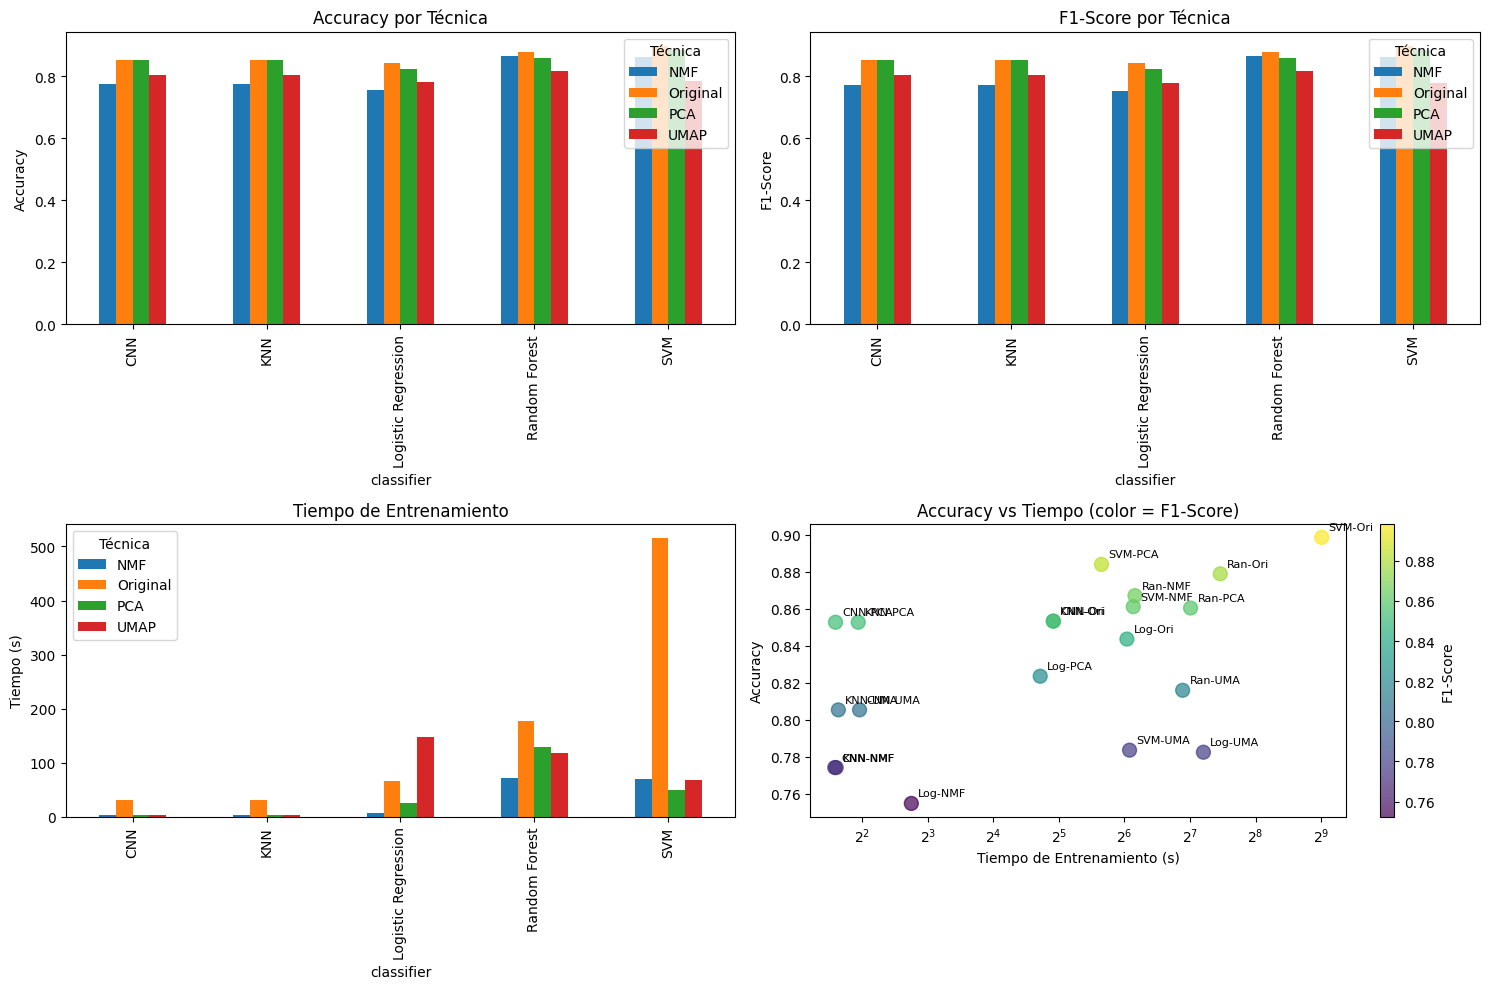

In [30]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

df_pivot = df_results.pivot(index='classifier', columns='technique', values='accuracy')
df_pivot.plot(kind='bar', ax=axes[0,0], title='Accuracy por Técnica')
axes[0,0].set_ylabel('Accuracy')
axes[0,0].legend(title='Técnica')

df_pivot_f1 = df_results.pivot(index='classifier', columns='technique', values='f1_score')
df_pivot_f1.plot(kind='bar', ax=axes[0,1], title='F1-Score por Técnica')
axes[0,1].set_ylabel('F1-Score')
axes[0,1].legend(title='Técnica')

df_pivot_time = df_results.pivot(index='classifier', columns='technique', values='train_time')
df_pivot_time.plot(kind='bar', ax=axes[1,0], title='Tiempo de Entrenamiento')
axes[1,0].set_ylabel('Tiempo (s)')
axes[1,0].legend(title='Técnica')

# --- Scatter: Accuracy vs Tiempo (color = F1-Score) ---
scatter = axes[1,1].scatter(df_results['train_time'], df_results['accuracy'],
                            c=df_results['f1_score'], cmap='viridis', alpha=0.7, s=100)
axes[1,1].set_xlabel('Tiempo de Entrenamiento (s)')
axes[1,1].set_ylabel('Accuracy')
axes[1,1].set_title('Accuracy vs Tiempo (color = F1-Score)')
axes[1,1].set_xscale('log', base=2)  # ✅ Escala logarítmica base 2
plt.colorbar(scatter, ax=axes[1,1], label='F1-Score')

# --- Anotaciones ---
for i, row in df_results.iterrows():
    axes[1,1].annotate(f"{row['classifier'][:3]}-{row['technique'][:3]}",
                       (row['train_time'], row['accuracy']),
                       xytext=(5, 5), textcoords='offset points', fontsize=8)

plt.tight_layout()
plt.show()

### Mejor modelo

=== MEJOR MODELO ===
Mejor modelo: SVM con Original

=== Reporte de Clasificación ===
              precision    recall  f1-score   support

 T-shirt/top       0.84      0.85      0.84      1000
     Trouser       0.99      0.97      0.98      1000
    Pullover       0.82      0.84      0.83      1000
       Dress       0.90      0.91      0.91      1000
        Coat       0.84      0.83      0.83      1000
      Sandal       0.97      0.97      0.97      1000
       Shirt       0.74      0.71      0.73      1000
     Sneaker       0.95      0.97      0.96      1000
         Bag       0.96      0.98      0.97      1000
  Ankle boot       0.97      0.96      0.96      1000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



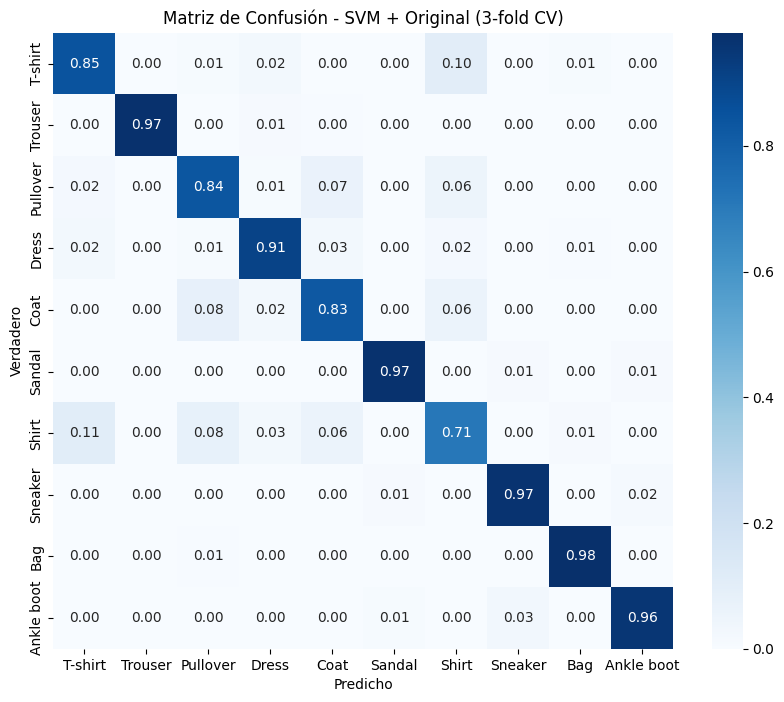

In [31]:
print("=== MEJOR MODELO ===")
# ordenar results por f1_score desc y train_time asc
results_sorted = sorted(
    results,
    key=lambda x: (-x['f1_score'], x['train_time'])
)

best_model_info = results_sorted[0]
best_model = best_model_info['modelo']
best_classifier = best_model_info['classifier']
best_technique = best_model_info['technique']
print(f"Mejor modelo: {best_classifier} con {best_technique}")

if best_technique == 'Original':
    X_test_best = X_test
elif best_technique == 'PCA':
    X_test_best = X_test_pca
elif best_technique == 'NMF':
    X_test_best = X_test_nmf
elif best_technique == 'UMAP':
    X_test_best = X_test_umap



# 🔹 Predicción sobre el set de validación
y_pred_best = best_model.predict(X_test_best)

# --- Reporte ---
print("\n=== Reporte de Clasificación ===")
print(classification_report(y_test, y_pred_best, target_names=[
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]))

# --- Matriz de Confusión Normalizada ---
cm = confusion_matrix(y_test, y_pred_best, normalize='true')
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=["T-shirt", "Trouser", "Pullover", "Dress", "Coat",
                         "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"],
            yticklabels=["T-shirt", "Trouser", "Pullover", "Dress", "Coat",
                         "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"])
plt.title(f"Matriz de Confusión - {best_classifier} + {best_technique} (3-fold CV)")
plt.ylabel("Verdadero")
plt.xlabel("Predicho")
plt.show()

In [32]:
# dill.dump_session('notebook_env.db')